От сотрудников Института Цитологии и Генетики СО РАН были получены данные о продолжительности жизни больных с боковым амиотрофическим склерозом(болезнь Стивена Хокинга), 
где Omega stability - некоторое значение, соответствующее мутации в белке, а Survival time - продолжительность жизни пациента при этой мутации.

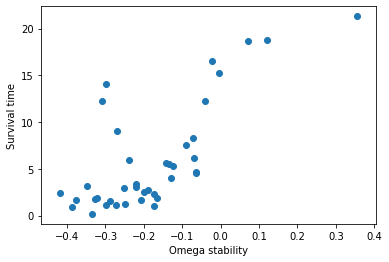

In [8]:
# Загрузим данные с помощью модуля Pandas в объект DataFrame
import numpy as np
import pandas as pd
omega_stability = pd.read_csv('omega_stability.csv')

# Проведем первичную обработку данных
omega_stability = omega_stability.T
omega_stability = omega_stability.drop(index = "Name")
omega_stability.columns = ["Omega stability", "Survival time"]

# Преобразуем значения ячеек в числовые
omega_stability["Omega stability"] = omega_stability["Omega stability"].astype(float)
omega_stability["Survival time"] = omega_stability["Survival time"].astype(float)

x = omega_stability["Omega stability"].values
y = omega_stability["Survival time"].values

# Проведем сортировку данных 
x, y = zip(*sorted(zip(x, y)))
x = np.asarray(x)
y = np.asarray(y)

# Проведем визуализацию
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
ax.set_xlabel('Omega stability')
ax.set_ylabel('Survival time')
ax.scatter(x, y)

Поставлена задача определить оптимальную регрессионную модель для прогнозирования времени дожития пациентов с БАС.

Будут рассмотрены следующие функции:
1. Линейная $$f(x) = a_{0} + a_{1}x$$
2. Кубическая $$f(x) = a_{0} + a_{1}x + a_{2}x^{2} + a_{3}x^{3}$$
3. Логистическая $$f(x) = \frac{a_{0}}{1 + e^{-a_{1}(x-a_{2})}}$$

In [11]:
# Проведем оценку параметров обычным МНК для линейной функции
np.polyfit(x, y, 1)[::-1]

array([10.90182755, 27.48041546])

In [12]:
# Проведем оценку параметров обычным МНК для кубической функции
np.polyfit(x, y, 3)[::-1]

array([  12.09694903,   49.76389461,    4.505014  , -179.41888585])

[2.47742715e+01 8.04350708e+00 5.72397837e-03]


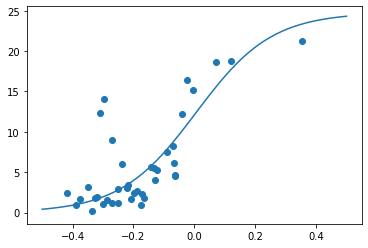

In [22]:
# Проведем оценку параметров нелинейным МНК для логистической функции
def logistic(a, x):
    return a[0]/(1 + np.exp(-a[1]*(x-a[2])))
# Функция остатков
def logistic_residual(a, x, y):
    return logistic(a, x) - y
from scipy.optimize import least_squares
a = least_squares(logistic_residual, np.ones(3), loss='linear', args=(x, y)).x
print(a)
fig, ax = plt.subplots()
x_plot = np.linspace(-0.5, 0.5, num=1000)
y_plot = logistic(a, x_plot)
ax.plot(x_plot, y_plot)
ax.scatter(x, y)

Далее необходимо создать метрику для оценки качества выбранной модели. Будем применять алгоритм перекрестной проверки
по К-группам. Тестовую выборку возьмем за 30% от изначальной. В результате получаем перспективную ошибку предсказания при тестировании модели на независимых данных.

In [27]:
from sklearn.model_selection import KFold
k = int(0.3*len(x))
kf = KFold(n_splits=k)
for train_index, test_index in kf.split(x):
    print("TRAIN:", train_index, "TEST:", test_index)

TRAIN: [ 4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38] TEST: [0 1 2 3]
TRAIN: [ 0  1  2  3  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38] TEST: [4 5 6 7]
TRAIN: [ 0  1  2  3  4  5  6  7 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38] TEST: [ 8  9 10 11]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 16 17 18 19 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38] TEST: [12 13 14 15]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 20 21 22 23 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38] TEST: [16 17 18 19]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 24 25 26 27
 28 29 30 31 32 33 34 35 36 37 38] TEST: [20 21 22 23]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 27 28 29 30 31 32 33 34 35 36 37 38] TEST: [24 25 26]
TRAIN: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 1